In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

In [153]:
def compare_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X, repeats=10):
    repeats = 10
    bs = np.zeros((repeats, len(theta_true)))
    ls = np.zeros((repeats, len(theta_true)))
    for i in range(repeats):
        Xs = generate_Xs(nk)
        y = likelihood.func(Xs, theta_true)
        bs[i] = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
        ls[i] = minimise_ls(y, likelihood, mean_X, theta_true).x
    print(f"Bayes: {bs.mean(axis=0)} +/- {bs.std(axis=0)}")
    print(f"LS: {ls.mean(axis=0)} +/- {ls.std(axis=0)}")

def plot_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X):
    Xs = generate_Xs(nk)
    y = likelihood.func(Xs, theta_true)

    theta_bayes = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
    theta_ls = minimise_ls(y, likelihood, mean_X, theta_true).x

    plt.plot(Xs, y, 'x', ms=2)
    plt.plot(Xs, likelihood.func(Xs, theta_bayes), label='bayes')
    plt.plot(Xs, likelihood.func(Xs, theta_ls), label='ls')
    plt.legend();
    print(f'bayes: {theta_bayes}')
    print(f'ls: {theta_ls}')
    return Xs, theta_bayes, theta_ls

def loss_theta(theta_true, theta_predicted):
    frac_diffs = (theta_true - theta_predicted)/theta_true
    return np.sum(frac_diffs**2)

In [3]:
def simple_logL_logX(logX, d):
    X = np.exp(logX)
    return -X**(2/d)

def simple_logX_logL(logL, d):
    return np.log((-logL)**(d/2))

def simple_logLprime_logX(logX, d):
    X = np.exp(logX)
    return - 2/d * X**(2/d - 1)

def logPr_bayes_logX(logL, mean, covinv, d):
    logXstar = simple_logX_logL(logL, d)
    abs_fprimes = abs(simple_logLprime_logX(logXstar, d))
    return - np.sum(abs_fprimes) - 1/2 * (logXstar - mean).T @ covinv @ (logXstar - mean)

In [4]:
nk = 500 * np.ones(1000)
# nk = data_at_iteration(samples_g_1, 1000)[0]
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

### Try on $X^{2/d}$

Bayes and least squares give same (correct) mean over many repeats

Bayes less consistent - greater spread in the mean

In [150]:
theta_true = np.array([10])
compare_bayes_ls(nk, theta_true, simple, mean_X, covinv_X, repeats=50)

Bayes: [9.96933747] +/- [0.40435234]
LS: [9.9157222] +/- [0.33621381]


bayes: [9.99131788]
ls: [9.6466845]


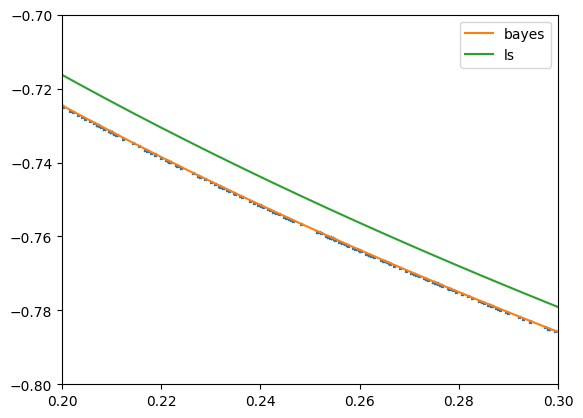

In [87]:
plot_bayes_ls(nk, 10, simple, mean_X, covinv_X)
plt.xlim(0.2, 0.3)
plt.ylim(-0.8, -0.7);

In [21]:
b = 0
l = 0
for i in range(1):
    dtrue = 10
    repeats = 20
    bs = np.zeros(repeats)
    ls = np.zeros(repeats)
    for i in range(repeats):
        Xs = generate_Xs(nk)
        y = simple.func(Xs, dtrue)
        bs[i] = minimise_bayes(y, simple, mean_X, covinv_X, dtrue).x
        ls[i] = minimise_ls(y, simple, mean_X, dtrue).x
    if bs.std() < ls.std():
        b += 1
    else:
        l += 1
print('b', b)
print('l', l)

b 0
l 1


In [152]:
b = 0
l = 0
theta_true = np.array([10])
for i in range(200):
    Xs = generate_Xs(nk)
    y = simple.func(Xs, dtrue)
    theta_b =  minimise_bayes(y, simple, mean_X, covinv_X, theta_true).x
    theta_l = minimise_ls(y, simple, mean_X, theta_true).x
    if loss_theta(theta_true, theta_b) < loss_theta(theta_true, theta_l):
        b += 1
    else:
        l += 1
print('b', b)
print('l', l)

b 74
l 126


### Try on $X^{2/d}/2\sigma^2$

In [127]:
theta_true = np.array([10, 0.1])
compare_bayes_ls(nk, theta_true , middle, mean_X, covinv_X, repeats=5)

Bayes: [9.82992665 0.10000241] +/- [4.24291993e-01 4.41005593e-05]
LS: [9.9536324  0.10005936] +/- [3.70159491e-01 1.82603617e-04]


bayes: [10.14514151  0.09996737]
ls: [9.93884151 0.09998608]


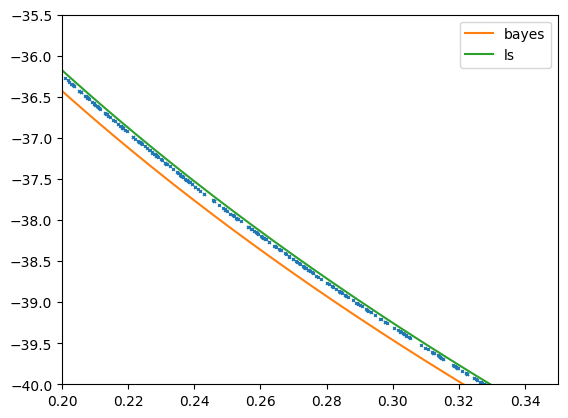

In [142]:
Xs, theta_b, theta_l = plot_bayes_ls(nk, theta_true, middle, mean_X, covinv_X)
plt.xlim(0.2, 0.35)
plt.ylim(-40, -35.5);

In [62]:
logL = middle.func(Xs, theta_true)
logPr_true = logPr_bayes(logL, middle, mean_X, covinv_X, theta_true)
logPr_bayesmax = logPr_bayes(logL, middle, mean_X, covinv_X, theta_b)
print(f'logPr = {logPr_true:.2f}, at {theta_true}')
print(f'logPr = {logPr_bayesmax:.2f}, at {theta_b}')

logPr = 5610.25, at [10.   0.1]
logPr = 5612.74, at [10.34230891  0.09996698]


In [148]:
b = 0
l = 0
theta_true = np.array([10, 0.1])
for i in range(200):
    Xs = generate_Xs(nk)
    y = simple.func(Xs, dtrue)
    theta_b =  minimise_bayes(y, middle, mean_X, covinv_X, theta_true).x
    theta_l = minimise_ls(y, middle, mean_X, theta_true).x
    if loss_theta(theta_true, theta_b) < loss_theta(theta_true, theta_l):
        b += 1
    else:
        l += 1
print('b', b)
print('l', l)

b 100
l 100


In [7]:
def L2_theta(theta_true, theta_predicted):
    frac_diffs = (theta_true - theta_predicted)/theta_true
    return np.sum(frac_diffs**2)

def target_X(theta):
    from scipy.special import gamma
    d, sigma = theta
    return 2**(d/2) * sigma**d * gamma(1 + d/2)

def Ltarget_theta(theta_true, theta_predicted):
    return abs(target_X(theta_true) - target_X(theta_predicted))

In [12]:
b = 0
l = 0
theta_true = np.array([10, 0.1])
for i in range(100):
    Xs = generate_Xs(nk)
    y = middle.func(Xs, theta_true)
    theta_b =  minimise_bayes(y, middle, mean_X, covinv_X, theta_true).x
    theta_l = minimise_ls(y, middle, mean_X, theta_true).x
    if Ltarget_theta(theta_true, theta_b) < Ltarget_theta(theta_true, theta_l):
        b += 1
    else:
        l += 1
    if (i % 5) == 0:
        print(f'{i}: bayes {b}, ls {l}')
print(f'{i}: bayes {b}, ls {l}')

0: bayes 0, ls 1
5: bayes 2, ls 4
10: bayes 5, ls 6
15: bayes 5, ls 11
20: bayes 10, ls 11
25: bayes 11, ls 15
30: bayes 11, ls 20
35: bayes 12, ls 24
40: bayes 14, ls 27
45: bayes 16, ls 30
50: bayes 18, ls 33
55: bayes 18, ls 38
60: bayes 18, ls 43
65: bayes 20, ls 46
70: bayes 22, ls 49
75: bayes 24, ls 52
80: bayes 25, ls 56
85: bayes 29, ls 57
90: bayes 30, ls 61
95: bayes 31, ls 65
99: bayes 33, ls 67
